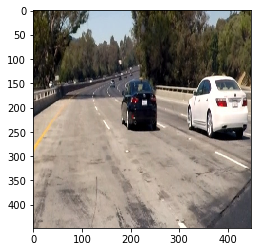

In [1]:
#carnd-vehicle dectection
import cv2
import glob
import matplotlib.pyplot as plt
import random
import numpy as np
from box import *

%matplotlib inline

image_list = []

vfiles = "vehicles/"
nvfiles = "vehicles/"

for filename in glob.glob('./CarND-Vehicle-Detection/test_images/*.jpg'):
    image_list.append(filename)

#index = random.randint(0, len(image_list)-1)
index = 0
jpgfile = image_list[index]
img = plt.imread(jpgfile)
img_crop = img[300:650,500:,:]
img_resize = cv2.resize(img_crop,(448,448))

plt.figure(figsize=(4,4))
plt.imshow(img_resize, cmap="gray")

In [2]:
transposed = np.transpose(img_resize,(2,0,1))
normalized = 2*(transposed/255.) - 1
batch = np.expand_dims(normalized, axis=0)

In [3]:
#build model and load yolo weights from pre-trained model
from train import *

model.summary()
out = model.predict(batch)
f = open("./data.md","w")
for i in out[0]:
    f.write("{0}\t".format(i))


Using TensorFlow backend.


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 16, 448, 448)  448         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
leakyrelu_1 (LeakyReLU)          (None, 16, 448, 448)  0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 16, 224, 224)  0           leakyrelu_1[0][0]                
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 32, 224, 224)  4640        maxpooling2d_1[0][0]             
___________________________________________________________________________________________

In [8]:
#get intersection area between two bounding box
def box_intersection(a, b):
    w = min(a.x + a.w/2., b.x + b.w/2.) - max(a.x - a.w/2., b.x - b.w/2.)
    h = min(a.y + a.h/2., b.y + b.h/2.) - max(a.y - a.h/2., b.y - b.h/2.)
    if w < 0 or h < 0: 
        return 0;
    else: 
        return w * h;

def box_combine(a, b):
    i = box_intersection(a, b);
    u = a.w * a.h + b.w * b.h - i;
    return u;

def GetOverlapRatio(a, b):
    if box_combine(a, b) != 0:
        return box_intersection(a, b) / box_combine(a, b);

def PredictCarBox(predictOut, threshold = 0.2, sqrt=2.0, C=20, B=2, S=7):
    class_num = 6
    boxes = []
    SS        =  S * S # number of grid cells
    prob_size = SS * C # class probabilities
    conf_size = SS * B # confidences for each grid cell
    
    probs = predictOut[0 : prob_size]
    confs = predictOut[prob_size : (prob_size + conf_size)]
    cords = predictOut[(prob_size + conf_size) : ]
    probs = probs.reshape([SS, C])
    confs = confs.reshape([SS, B])
    cords = cords.reshape([SS, B, 4])
    
    for grid in range(SS):
        for b in range(B):
            bx   = Box()
            bx.c =  confs[grid, b]
            bx.x = (cords[grid, b, 0] + grid %  S) / S
            bx.y = (cords[grid, b, 1] + grid // S) / S
            bx.w =  pow(cords[grid, b, 2], sqrt) 
            bx.h =  pow(cords[grid, b, 3], sqrt)
            p = probs[grid, :] * bx.c
            
            if p[class_num] >= threshold:
                bx.prob = p[class_num]
                boxes.append(bx)
                
    # combine boxes that are overlap
    boxes.sort(key=lambda b:b.prob,reverse=True)
    for i in range(len(boxes)):
        boxi = boxes[i]
        if boxi.prob == 0: continue
        for j in range(i + 1, len(boxes)):
            boxj = boxes[j]
            if GetOverlapRatio(boxi, boxj) >= .4:
                boxes[j].prob = 0.
    boxes = [b for b in boxes if b.prob > 0.]
    
    return boxes

boxes = PredictCarBox(out[0], threshold = 0.17)
for b in boxes:
    print([b.x, b.y, b.w, b.h])

[-6.2443885803222656, 22.23392595563616, 2177.4734942449722, 1823.8973605994979]
[8.1763703482491632, 2.4748785836356029, 420.87584318220615, 633.60562289156951]
[-7.6249623979840964, -4.1853103637695312, 3655.9590410698584, 11427.779967978189]
[39.074292864118306, 5.6808046613420755, 42097.977821622044, 32.97495707947769]
[-3.2266101837158203, -8.3505581447056354, 3163.0630805657856, 3610.5449726496736]
[-13.818937029157366, 18.408437456403458, 213.93004241378458, 5060.5619251030148]
[1.5318431173052107, -5.3705831255231589, 371.11749337709989, 10926.247901296301]
[-0.36035473006112234, -3.1194964817592075, 137.45633478127365, 16792.321420513326]
[-18.485462733677455, 24.96602303641183, 31048.148896806175, 263.02700191329131]
[18.209995814732142, -6.85974611554827, 4270.4358333386481, 650.95543337824347]
[4.1464734758649557, -19.608760288783483, 403.16572382865706, 2888.5655044692103]
[10.283409118652344, 11.294999258858818, 197.08981332987605, 22.75501516451186]
[10.924356733049665, 

In [5]:
#draw boxes
def draw_box(boxes,im,crop_dim):
    imgcv = im
    [xmin,xmax] = crop_dim[0]
    [ymin,ymax] = crop_dim[1]
    for b in boxes:
        h, w, _ = imgcv.shape
        left  = int ((b.x - b.w/2.) * w)
        right = int ((b.x + b.w/2.) * w)
        top   = int ((b.y - b.h/2.) * h)
        bot   = int ((b.y + b.h/2.) * h)
        left = int(left*(xmax-xmin)/w + xmin)
        right = int(right*(xmax-xmin)/w + xmin)
        top = int(top*(ymax-ymin)/h + ymin)
        bot = int(bot*(ymax-ymin)/h + ymin)

        if left  < 0    :  left = 0
        if right > w - 1: right = w - 1
        if top   < 0    :   top = 0
        if bot   > h - 1:   bot = h - 1
        thick = int((h + w) // 150)
        cv2.rectangle(imgcv, (left, top), (right, bot), (255,0,0), thick)

    return imgcv

#f,(ax1,ax2) = plt.subplots(1,2,figsize=(16,6))
#ax1.imshow(img)
#ax2.imshow(draw_box(boxes,img,[[500,1280],[300,650]]))

In [6]:
#detect on video
from moviepy.editor import VideoFileClip

def videoPipline(image):
    crop = image[300:650,500:,:]
    resized = cv2.resize(crop,(448,448))
    batch = np.array([resized[:,:,0],resized[:,:,1],resized[:,:,2]])
    batch = 2*(batch/255.) - 1
    batch = np.expand_dims(batch, axis=0)
    out = model.predict(batch)
    boxes = PredictCarBox(out[0], threshold = 0.17)
    return draw_box(boxes,image,[[500,1280],[300,650]])

project_video_output = './project_output.mp4'
clip1 = VideoFileClip("./CarND-Vehicle-Detection/project_video.mp4")

lane_clip = clip1.fl_image(videoPipline) #NOTE: this function expects color images!!
%time lane_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video ./project_output.mp4
[MoviePy] Writing video ./project_output.mp4


100%|█████████▉| 1260/1261 [28:42<00:01,  1.34s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_output.mp4 

CPU times: user 1h 37min 3s, sys: 3min 4s, total: 1h 40min 8s
Wall time: 28min 43s
